<a href="https://colab.research.google.com/github/lucadonnoh/progetto-deblur/blob/main/Progetto_Deblur_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [ ]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n)) 
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

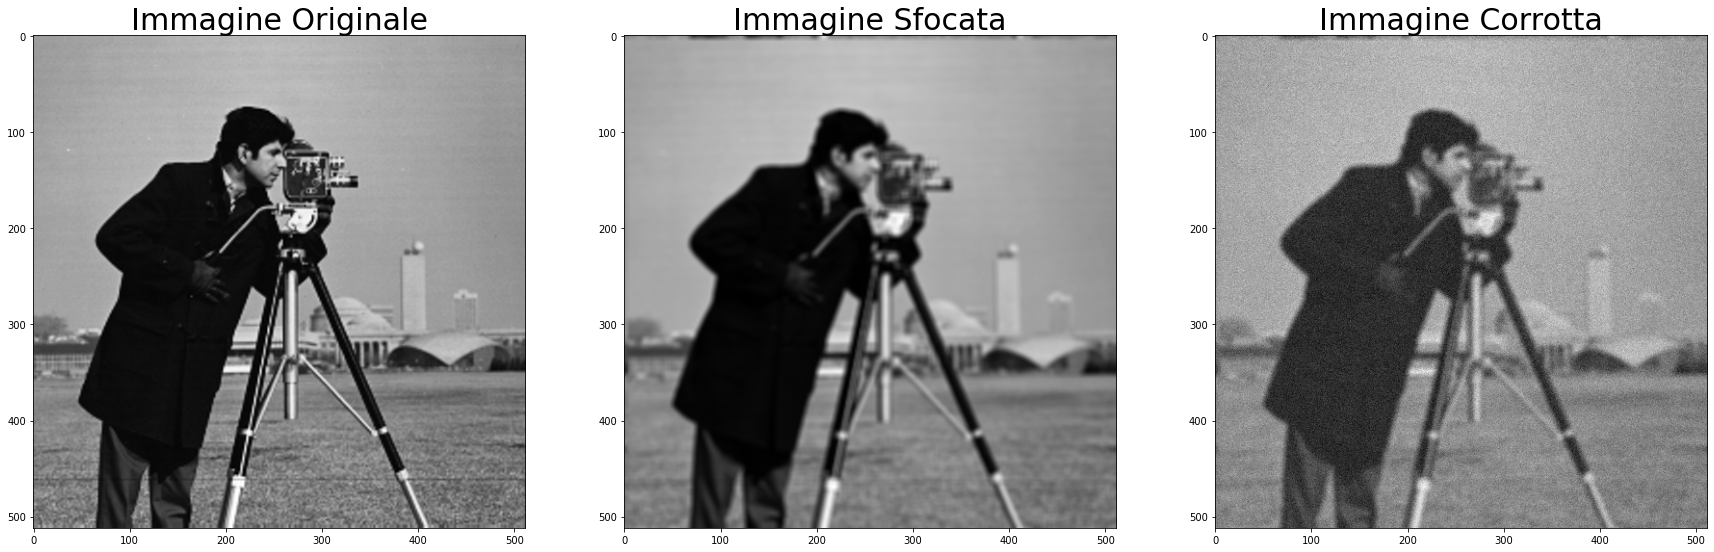

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n) # array m*n


# 2
X_blur = A(X) # matrice
x_blur = X_blur.reshape(m*n) # array


# 3
# Generiamo il rumore eta
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape) # random gaussian distribution
eta /= np.linalg.norm(eta, 'fro') # norma di frobenius
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [ ]:
# 4 - 5 
#Modificare l'algoritmo è stato interpretato come "sovrascrivere il precedente"

def f(x, b): #
  return 0.5*(np.linalg.norm(A(x)-b))**2

def grad_f(x, b):
  return AT(A(x)-b)

def next_step(x, b, f, grad):
  alpha = 0.5
  rho = 0.5
  c1 = 0.25
  k = 0

  while f(x-alpha*grad, b) > f(x, b) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize(x0, x_true, b, maxit, abstop):
  x = x0
  grad = grad_f(x, b)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step(x, b, f, grad) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f(x, b)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


..................................................
 [10405.93500736  9698.65990962  9426.72596725  9322.25591662
  9304.80051116  9340.60625932  9412.49387397  9510.50978213
  9628.31341935  9761.56718141  9907.13831506 10062.66850141
 10226.32499968 10396.64808083 10572.45270168 10752.76235247
 10936.76286214 11123.7690803  11313.20016203 11504.56078292
 11697.42655865 11891.43252216 12086.26387558 12281.64846937
 12477.35061701 12673.16595868 12868.91716115 13064.45029179
 13259.63174262 13454.34560679 13648.49143067 13841.9822798
 14034.74306892 14226.70911514 14417.82488101 14608.04287954
 14797.32271802 14985.6302613  15172.93689798 15359.21889588
 15544.45683472 15728.63510612 15911.74147229 16093.76667586
 16274.7040946  16454.54943554 16633.30046352 16810.95676024
 16987.51951007 17162.99130956]


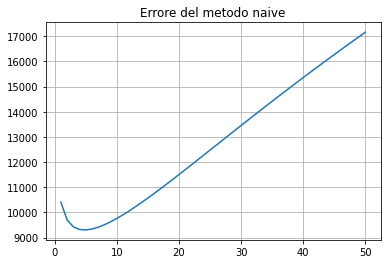

....

In [70]:
def plot( iters, error, title): 
  err_iteration = np.linspace(1, iters, error.size)
  plt.plot(err_iteration, err_naive)
  plt.title(title)
  plt.grid()
  plt.show()

def find_x_trunc(error):
  return np.where(error == np.amin(error))[0]

MAXITERATIONS=50
ABSOLUTE_STOP=1.e-5

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(x_naive, ite_naive, err_naive) = minimize(B, X, B, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_naive)
plot(ite_naive, err_naive,"Errore del metodo naive")

X_trunc_index = find_x_trunc(err_naive)
X_trunc,_,_= minimize(x0,X,B,X_trunc_index, ABSOLUTE_STOP)



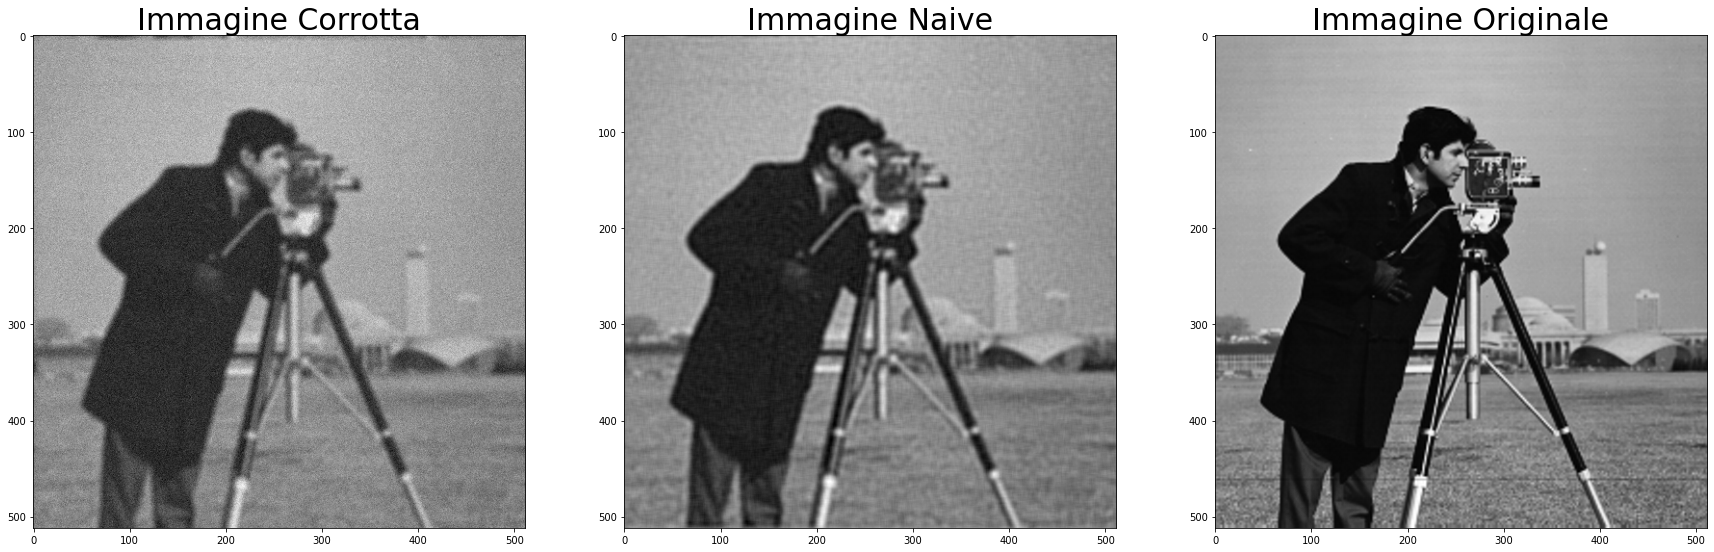

In [56]:
#Plottiamo il risultato
plt.figure(figsize=(30, 10))

fig1 = plt.subplot(1, 3, 1)
fig1.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig2 = plt.subplot(1, 3, 2)
fig2.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig3 = plt.subplot(1, 3, 3)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [68]:
def f_reg(x, b, lamb): #
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2

def grad_f_reg(x, b, lamb):
  return AT(A(x)-b) + lamb*x

def next_step_reg(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg(x-alpha*grad, b, lamb) > f_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

In [137]:
def lamb_ottimale(x, b, max):
  lamb=0.000000001
  k=0
  print(np.linalg.norm(eta)**2)
  print(np.linalg.norm(A(x)-b)**2)
  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb +=0.000000001
    x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
    k+=1
  print(k)
  return lamb

..................................................
 [10021.14058916  6677.95244456  6327.16903528  6205.8522033
  6188.38174343  6236.08075243  6329.06089774  6455.30776316
  6606.79231183  6777.77774279  6963.97964503  7162.10252853
  7369.56018856  7584.29428889  7804.649802    8029.28574578
  8257.10915087  8487.22505029  8718.89792947  8951.52160466
  9184.59543289  9417.70535639  9650.50868652  9882.72181021
 10114.11020042 10344.48025655 10573.67260759 10801.55659159
 11028.02568603 11252.99371057 11476.39166046 11698.16505664
 11918.27172128 12136.67990486 12353.36670473 12568.31672637
 12781.5209473  12992.97575077 13202.68210209 13410.64484534
 13616.87210161 13821.37475346 14024.16600251 14225.26098943
 14424.67646701 14622.43051881 14818.54231684 15013.03191259
 15205.92005702 15397.22804527]


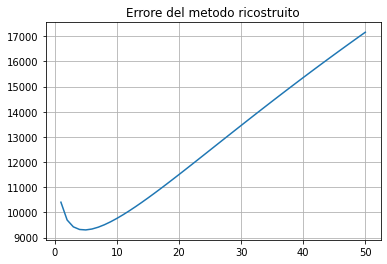

[6188.38174343]
....

In [116]:
lamb = 0.0001001111 #lambda con metodo euristico
x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(x_rec, ite_rec, err_reg) = minimize_reg(x0, X, B, lamb, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg)
plot(ite_rec, err_reg,"Errore del metodo ricostruito")

X_reg_index = find_x_trunc(err_reg)
print(err_reg[X_reg_index])
X_lambda,_,_= minimize_reg(x0,X,B, lamb,X_reg_index, ABSOLUTE_STOP)

In [138]:
lambda_giusto = lamb_ottimale(B, B, X_reg_index)
print(lambda_giusto)

45847986.30452475
114907151.02122214
0
1e-09


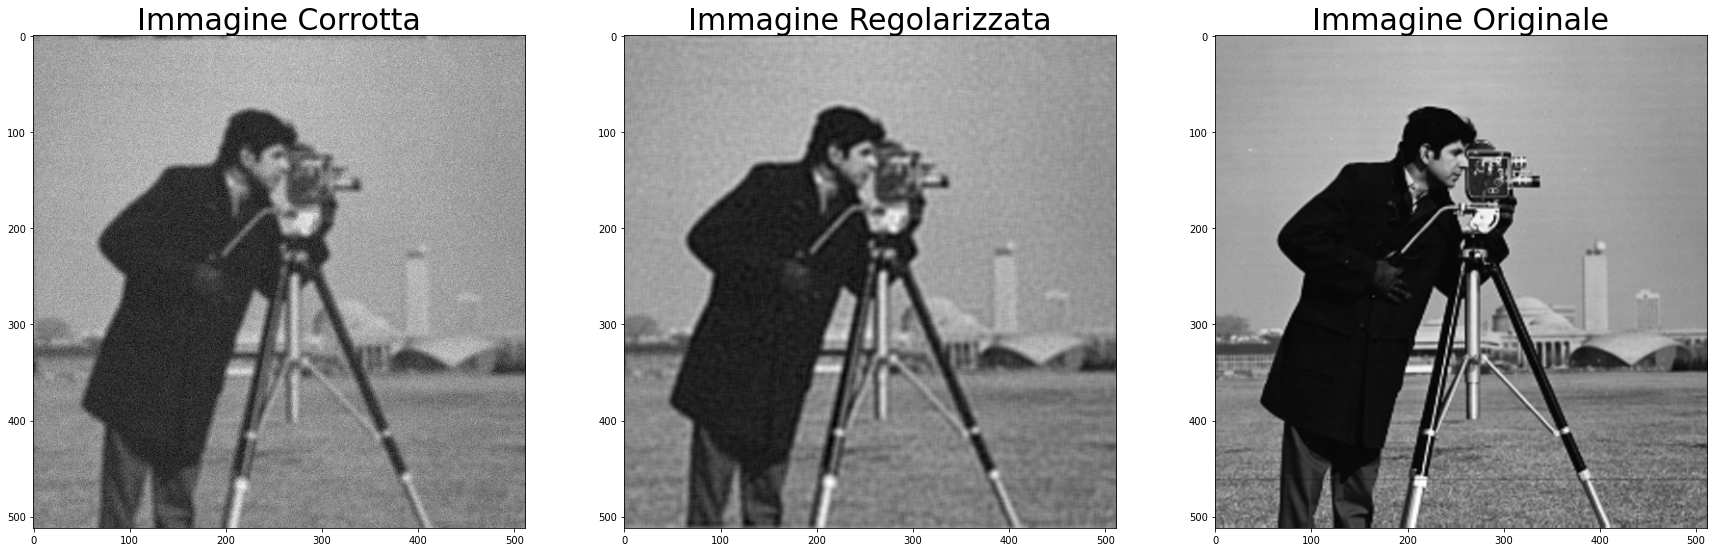

In [112]:
#Plottiamo il risultato
plt.figure(figsize=(30, 10))

fig1 = plt.subplot(1, 3, 1)
fig1.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig2 = plt.subplot(1, 3, 2)
fig2.imshow(X_reg, cmap='gray')
plt.title('Immagine Regolarizzata', fontsize=30)

fig3 = plt.subplot(1, 3, 3)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [ ]:
def f_reg_1(x, b, lamb): #
  return 0.5*(np.linalg.norm(A(x)-b))**2 + lamb*np.linalg.norm(x, 1)**2

def grad_f_reg_1(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_1(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_1(x-alpha*grad, b, lamb) > f_reg_1(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_1(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_1(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_1(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_1(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

In [ ]:
#trovare il lamba ottimale

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [140]:
#TODO: va definito mu

def f_reg_mista(x, b, lamb): 
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2 + mu*np.linalg.norm(x1,1)

def grad_f_reg_mista(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_mista(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_mista(x-alpha*grad, b, lamb) > f_reg_mista(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_mista(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_mista(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_mista(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_mista(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

In [ ]:
#trovare il lamba ottimale

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

